# 2D effective index approximation of 3D simulations

Large-scale 3D FDTD simulations are often required for accurate results but are associated with significant time and costs. Therefore, the development of methods to approximate 3D simulations using 2D models presents notable advantages. For instance, during the initial phase of design exploration, employing 2D simulations can effectively narrow down the range of parameters, with 3D simulations subsequently refining and finalizing the design.

This notebook introduces an efficient index approximation method that enables the approximation of 3D FDTD simulations through 2D simulations, substantially reducing computational resources and simulation times, potentially by orders of magnitude, while still retaining a reasonable level of accuracy. This method is particularly suitable for modeling integrated photonic devices that support waveguide modes. We first outline the process for calculating the effective permittivity for the 2D simulation using the variational method.

Following this, we compare the results of 1D approximation of a 2D device, and a 2D approximation of a 3D device to validate the approximation method's effectiveness. The findings indicate that, when applied appropriately, the approximated simulation maintains an acceptable fidelity to the corresponding full simulation response.

<a href="https://doi.org/10.1007/s11082-009-9349-3"><img src="img/effective_index_approximation.png" width="500" alt="Schematic of 2D-ifying" ></a>

First we start by importing the necessary libraries for our simulations:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.dispersion import FastDispersionFitter, AdvancedFastFitterParam

## Variational Effective Permittivity

In order to match the material of our 2D structures with those of the corresponding 3D structures, we will calculate the <b>variational effective permittivity</b>, taken from `Manfred Hammer and Olena V. Ivanova, "Effective index approximations of photonic crystal slabs: a 2-to-1-D assessment," Opt Quant Electron 41, 267–283 (2009)`[DOI:10.1007/s11082-009-9349-3](https://doi.org/10.1007/s11082-009-9349-3):<br>
$$
\epsilon_{eff}(x,y)=n_{eff}(x_r,y_r)^2+\frac{\int_z[\epsilon(x,y,z)-\epsilon(x_r,y_r,z,\omega)]|M_r(z,\omega)|^2dz}{\int_z|M_r(z,\omega)|^2dz},
$$<br>
where $x_r,y_r$ are the coordinates of the reference point, $n_{eff}(x_r,y_r)$ is the effective index of the slab waveguide, given the permittivity profile in the z direction, at the reference point, $\epsilon$ is the permittivity profile, and $M_{ref}(z,\omega)$ is the mode profile in $z$ at the reference point. This formula is based on the assumption that the different vertical slab modes remain relatively uncoupled.<br><br>

The reference profile in $z$ at point $(x_r,y_r)$ is what we choose to compare other $z$ profiles against. In our examples, we choose this point to include the location of our waveguide.<br><br>

Note: This is only the effective permittivity for the TE mode. A separate TM mode formula exists, and the interested user should refer to the TM formula given in the paper. Also, in the paper, the extrusion dimension is x. In our examples, the extrusion dimension is z.

In [2]:
import scipy.interpolate
from tidy3d.plugins.mode.web import run as run_mode_solver


def var_eps_eff(point, ref_point, sim, wavelength=1.55, inf=1000, min_n=1, remote=False):
    """
    To calculate the vertical slab mode at 'ref_point', we will create a 2D slice of the given simulation at
    'ref_point' that extends in the yz plane infinitely, ensuring that it captures the entire permittivity
    profile. Then, to find the 1D mode profile, we use the Tidy3D ModeSolver on a plane at 'ref_point' that
    extends infinitely in the xz plane. This results in the ModeSolver operating on the intersecting line
    at 'ref_point' that covers its entire z profile. We then use this to solve for n_eff and M in the above
    formula.

    The min_n parameter is set to ensure that the calculated refractive index is at least 1. This
    calculation can well end up with a value less than 1, as mentioned in the paper. To ensure that the
    returned refractive index is physical, we set min_n to 1 by default.

    There is also the option to use the remote mode solver if the user desires greater accuracy.
    """
    freq = td.C_0 / wavelength

    sim_2d_center = (
        ref_point[0],
        ref_point[1],
        0,
    )  # given a 3D sim, we update the center to create our 2D slice
    sim_2d_size = (
        0,
        inf,
        inf,
    )  # we ensure the 2D span of the simulation in the yz plane captures everything

    # now we create the 2D simulation, keeping the structures and updating the boundary conditions
    sim_2d = sim.updated_copy(
        center=sim_2d_center,
        size=sim_2d_size,
        sources=[],
        monitors=[],
        symmetry=(0, 0, 0),
        boundary_spec=sim.boundary_spec.updated_copy(x=td.Boundary.periodic()),
    )

    # Now we solve for the mode at 'ref_point':
    # We create the plane in xz that we'll use to examine the mode in z
    mode_solver_plane = td.Box(center=sim_2d.center, size=(td.inf, 0, td.inf))
    # Now we define the mode solver using this plane. We need only solve for one mode here, hence the ModeSpec
    mode_solver = td.plugins.mode.ModeSolver(
        simulation=sim_2d, plane=mode_solver_plane, mode_spec=td.ModeSpec(num_modes=1), freqs=[freq]
    )

    # Note that here the mode solving is done locally. For users desiring more accuracy, the remote mode
    # solver should be used.
    if remote:
        mode_data_ref = run_mode_solver(mode_solver)
    else:
        mode_data_ref = mode_solver.solve()

    # get n_eff from the solver
    n_eff = mode_data_ref.n_eff.item()
    if point == ref_point:
        return n_eff**2  # if point is the reference point, the integral is 0

    # get z permittivity profile at 'ref_point'
    x, y = ref_point
    eps_ref = sim.epsilon(
        box=td.Box(center=(x, y, list(sim.center)[2]), size=(0, 0, td.inf)), freq=freq
    )

    # get z permittivity profile at 'point'
    x, y = point
    eps = sim.epsilon(
        box=td.Box(center=(x, y, list(sim.center)[2]), size=(0, 0, td.inf)), freq=freq
    )

    eps_dif = np.squeeze(eps.values) - np.squeeze(eps_ref.values)

    # get M at the same z coordinates as those of (eps - eps_ref) so we can integrate their product
    z_coords = eps_ref.z.values
    mode_profile = mode_data_ref.Ex
    Mz2 = scipy.interpolate.interp1d(
        x=mode_profile.z.values, y=np.abs(np.squeeze(mode_profile.values)) ** 2
    )
    m_values = Mz2(z_coords)

    # calculate integrals
    num, denom = np.trapz(y=eps_dif * m_values, x=z_coords), np.trapz(y=m_values, x=z_coords)

    if n_eff**2 + num / denom < min_n:
        return min_n
    return n_eff**2 + num / denom

Here we create a function that uses the above function to create the approximated materials used in the 2D simulation. It takes as input the 3D simulation, the mode reference point, the point describing the stack that the user would like to approximate, and the simulation spectrum.

In [3]:
def approximate_material(sim_3D, approx_point, ref_point, spectrum, min_n=1, plot=False):
    eps = []
    for wl in spectrum:  # at every [step]th wavelength, calculate the effective permittivity
        eps.append(var_eps_eff(approx_point, ref_point, sim_3D, wavelength=wl, min_n=min_n))

    # fit the materials with the FastDispersionFitter using the calculated effective permittivities
    fitter = FastDispersionFitter(wvl_um=spectrum, n_data=np.sqrt(np.real(eps)))

    # create the mediums using the material fit
    medium, rms_error = fitter.fit()

    if plot:
        # plot the material fit
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        fitter.plot(medium, ax=ax)
        ax.set_title("Medium")
        plt.show()

    return medium

Here we create a function that, given a 3D simulation, creates a 2D copy with updated materials given by the user. This, like the previous function, is provided so Tidy3D users can easily 2D-ify their 3D simulations.

In [4]:
def create_2D_sim(sim_3D, new_mediums):
    # Redo the structures that were in our 3D simulation with our calculated material approximations
    new_structures = []
    for structure in sim_3D.structures:
        new_structures.append(structure.updated_copy(medium=new_mediums[0]))

    # Update the size to 3D
    new_size = list(sim_3D.size)
    new_size[2] = 0

    # Update the symmetry to 2D
    new_symmetry = list(sim_3D.symmetry)
    if new_symmetry != [0, 0, 0]:
        print(
            "Note: removed symmetry, as it is incompatible with the variational approximation method."
        )
    new_symmetry = (0, 0, 0)

    # Create the 2D version of our 3D original
    sim_2D = sim_3D.updated_copy(
        size=new_size,
        structures=new_structures,
        boundary_spec=sim_3D.boundary_spec.updated_copy(z=td.Boundary.periodic()),
        medium=new_mediums[1],
        symmetry=new_symmetry,
    )

    return sim_2D

Since the method that calculates the variational effective permittivity creates a 2D simulation from the given 3D simulation, generally there can be some objects (and symmetries) not included in the 2D simulation, which will throw some warnings. Furthermore, since we're using the local mode solver, Tidy3D will also print a warning that the remote mode solver should be used for greater accuracy. Since we're okay with this, it will be cleaner to suppress the warnings.

In [5]:
# Suppress warnings for some of the structures not being included in the 2D simulation
td.config.logging_level = "ERROR"

The above four code cells are all that is needed to use this approximation for a 3D simulation given by the user.

## Example 1: 2D Planar Waveguide Bragg Grating
To see this in action, we will apply this to a 2-dimensional waveguide Bragg grating described in the source paper.<br>

First we quickly build the 2D simulation:

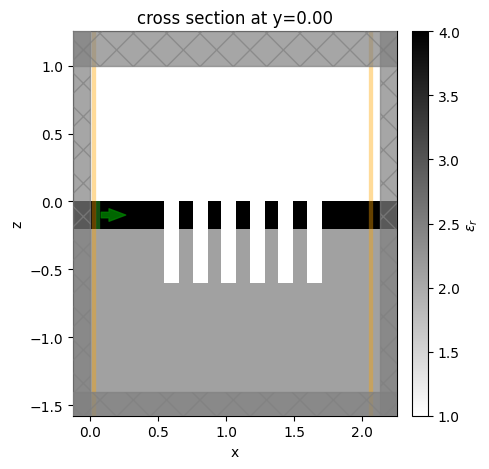

In [6]:
# Define wavelength/frequency ranges
ldas = np.linspace(0.4, 0.9, 101)
lda0 = ldas[50]
freqs = td.C_0 / ldas
freq0 = td.C_0 / lda0

# Refractive indices
n_c = 1
n_f = 2
n_s = 1.45

# Materials used
air = td.Medium(permittivity=n_c**2)
top_medium = td.Medium(permittivity=n_f**2)
bottom_medium = td.Medium(permittivity=n_s**2)

# Define geometries and their structures
hole_length = 0.11
hole_depth = 0.6
hole_spacing = 0.21
top_thickness = 0.2

inf = 10

holes_list = []
for h in range(6):
    holes_list.append(
        td.Box(
            center=(hole_depth + h * hole_spacing, 0, 0), size=(hole_length, inf, 2 * hole_depth)
        )
    )
holes_geos = td.GeometryGroup(geometries=holes_list)
holes = td.Structure(geometry=holes_geos, medium=air)

top_geo = td.Box.from_bounds(rmin=(-inf, -inf, -top_thickness), rmax=(inf, inf, 0))
bottom_geo = td.Box.from_bounds(rmin=(-inf, -inf, -inf), rmax=(inf, inf, 0))

top = td.Structure(geometry=top_geo, medium=top_medium)
bottom = td.Structure(geometry=bottom_geo, medium=bottom_medium)

# The injection used in the paper is a plane wave source
source = td.PlaneWave(
    center=(hole_depth * 0.1, 0, -top_thickness / 2),
    size=(0, inf, top_thickness),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqs[0] - freqs[-1]),
    direction="+",
)

# Add monitors
reflection = td.FluxMonitor(
    center=(hole_depth * 0.05, 0, 0), size=(0, inf, inf), name="R", freqs=freqs, normal_dir="-"
)
transmission = td.FluxMonitor(
    center=(hole_depth + 7 * hole_spacing, 0, 0), size=(0, inf, inf), name="T", freqs=freqs
)

# Define the simulation of adequate size
sim_size_x = hole_depth * 1.1 + 7 * hole_spacing
sim_2d = td.Simulation(
    center=(sim_size_x / 2, 0, -hole_depth / 3),
    size=(sim_size_x, 0, 4 * hole_depth),
    medium=air,
    structures=[bottom, top, holes],
    sources=[source],
    monitors=[reflection, transmission],
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ),
    grid_spec=td.GridSpec.auto(wavelength=lda0, min_steps_per_wvl=30),
    run_time=150 / freq0,
)

# Visualize the simulation to check
sim_2d.plot_eps(y=0)
plt.show()

Next we calculate the variational effective indices at different steps in our input wavelengths. We will then fit a dispersive material to this data using Tidy3D's FastDispersionFitter.<br><br>
To speed things up, we will reduce the number of times we need to solve for the mode, so we will downsample the wavelength points. Here we calculate the effective permittivity at every fifteenth wavelength.

Output()

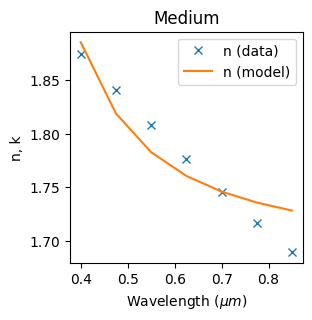

In [7]:
# Downsample wavelengths to speed up the calculation
spectrum = ldas[::15]
waveguide_mat = approximate_material(sim_2d, (0.25, 0), (0.25, 0), spectrum, plot=True)

In [8]:
hole_mat = approximate_material(sim_2d, (1, 0), (0.25, 0), spectrum)

Output()

We now create the 1D simulation with the calculated mediums:

In [9]:
# Redo the structures that were in our 2D simulation with our calculated material approximations
holes_list_1D = []
for h in range(6):
    holes_list_1D.append(
        td.Box(center=(hole_depth + h * hole_spacing, 0, 0), size=(hole_length, inf, inf))
    )
holes_geos_1D = td.GeometryGroup(geometries=holes_list_1D)
holes_1D = td.Structure(geometry=holes_geos_1D, medium=hole_mat)

# Update the size to 1D
new_size = list(sim_2d.size)
new_size[2] = 0

# Update the plane wave source for 1D
source_1d = td.PlaneWave(
    center=sim_2d.sources[0].center,
    size=sim_2d.sources[0].size,
    source_time=sim_2d.sources[0].source_time,
    direction=sim_2d.sources[0].direction,
)

# Create the 1D version of our 2D original
sim_1d = sim_2d.updated_copy(
    size=new_size,
    structures=[holes_1D],
    sources=[source_1d],
    boundary_spec=sim_2d.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=waveguide_mat,
)

Finally, we run both simulations.

In [10]:
sim_2d_data = web.run(sim_2d, task_name="var eps")
sim_1d_data = web.run(sim_1d, task_name="var eps")

13:30:09 EST Created task 'var eps' with task_id                                
             'fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=361464;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=633718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\taskId]8;;\]8;id=361464;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\=]8;;\]8;id=509360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\fdve]8;;\]8;id=361464;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\-329f73f4-e53]8;;\
             ]8;id=361464;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\d-4f75-ace2-c6c16f717e99']8;;\.

Output()

13:30:10 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:30:15 EST status = preprocess

13:30:18 EST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

13:30:23 EST early shutoff detected at 32%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=654369;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=151246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\taskId]8;;\]8;id=654369;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\=]8;;\]8;id=274211;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\fdve]8;;\]8;id=654369;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\-329f73f4-e53]8;;\
             ]8;id=654369;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329f73f4-e53d-4f75-ace2-c6c16f717e99\d-4f75-ace2-c6c16f717e99']8;;\.

Output()

             loading simulation from simulation_data.hdf5

13:30:24 EST Created task 'var eps' with task_id                                
             'fdve-a22f27be-15ef-47df-9295-9517dd74ed5d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=952247;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=483630;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\taskId]8;;\]8;id=952247;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\=]8;;\]8;id=261785;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\fdve]8;;\]8;id=952247;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\-a22f27be-15e]8;;\
             ]8;id=952247;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\f-47df-9295-9517dd74ed5d']8;;\.

Output()

13:30:25 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:30:37 EST status = preprocess

13:30:38 EST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

13:30:42 EST early shutoff detected at 40%, exiting.

             status = postprocess

Output()

13:30:43 EST status = success

             View simulation result at                                          
             ]8;id=518606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=935109;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\taskId]8;;\]8;id=518606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\=]8;;\]8;id=510209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\fdve]8;;\]8;id=518606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\-a22f27be-15e]8;;\
             ]8;id=518606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a22f27be-15ef-47df-9295-9517dd74ed5d\f-47df-9295-9517dd74ed5d']8;;\.

Output()

13:30:44 EST loading simulation from simulation_data.hdf5

### Example 1 Result Comparison

Now that both the 2D and 1D simulations have run, we will compare their results to see how representative the 1D simulation is. The results of the 1D approximation retain a reasonable qualitative fidelity to the 2D version.

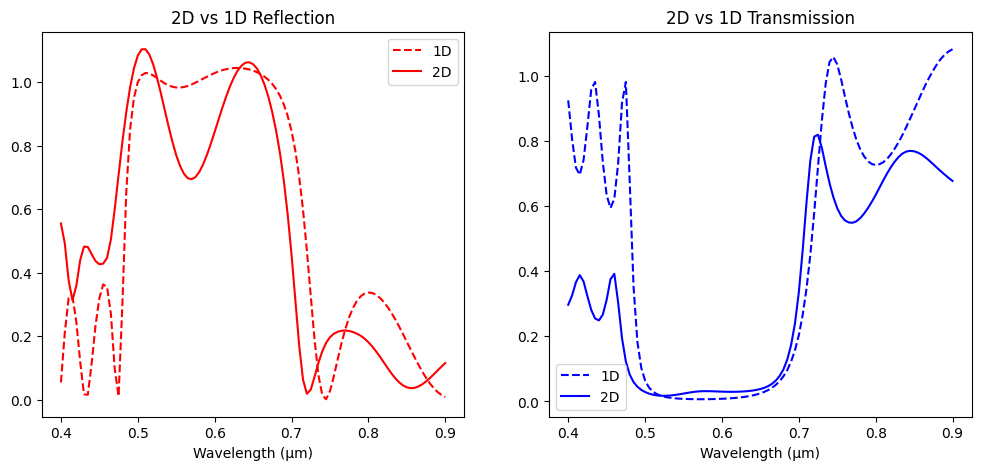

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(
    td.C_0 / sim_1d_data["R"].flux.f,
    sim_1d_data["R"].flux.data,
    label="1D",
    color="red",
    linestyle="--",
)
ax[0].plot(td.C_0 / sim_2d_data["R"].flux.f, sim_2d_data["R"].flux.data, label="2D", color="red")
ax[0].set_title("2D vs 1D Reflection")
ax[0].set_xlabel("Wavelength (µm)")
ax[0].legend()

ax[1].plot(
    td.C_0 / sim_1d_data["R"].flux.f,
    sim_1d_data["T"].flux.data,
    label="1D",
    color="blue",
    linestyle="--",
)
ax[1].plot(td.C_0 / sim_2d_data["R"].flux.f, sim_2d_data["T"].flux.data, label="2D", color="blue")
ax[1].set_title("2D vs 1D Transmission")
ax[1].set_xlabel("Wavelength (µm)")
ax[1].legend()

plt.show()

## Example 2: Ring Resonator

We will now apply this same method to transform a 3D simulation into its 2D approximation. We will use a ring resonator and check the transmission of the through ports of both setups.<br><br>
First we quickly build the 3D simulation:

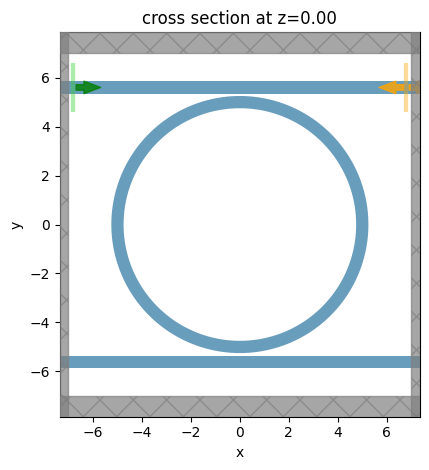

In [12]:
# Define wavelength/frequency ranges
lambda_beg = 1.5
lambda_end = 1.6
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5
lambdas_ring = np.linspace(lambda_beg, lambda_end, 301)
freqs_ring = td.C_0 / lambdas_ring[::-1]

# Refractive indices
Si_n = 3.4777
SiO2_n = 1.444

# Materials used
Si = td.Medium(permittivity=Si_n**2)
SiO2 = td.Medium(permittivity=SiO2_n**2)

# Define geometries and their structures
h_clad = 2.8
h_box = 2
h_wafer = 0.5

w_wg = 0.5
h_wg = 0.22
couple_gap = 0.1
ring_radius = 5

z_wafer = -h_box - h_wafer / 2

y_wg = ring_radius + w_wg / 2 + couple_gap + w_wg / 2

waveguide_top = td.Structure(
    geometry=td.Box(
        center=[0, y_wg, 0],
        size=[td.inf, w_wg, h_wg],
    ),
    medium=Si,
)

waveguide_bottom = td.Structure(
    geometry=td.Box(
        center=[0, -y_wg, 0],
        size=[td.inf, w_wg, h_wg],
    ),
    medium=Si,
)

wg_ring_geo = td.Cylinder(
    center=[0, 0, 0], axis=2, radius=ring_radius + w_wg / 2.0, length=h_wg
) - td.Cylinder(center=[0, 0, 0], axis=2, radius=ring_radius - w_wg / 2.0, length=w_wg * 1.5)

wg_ring = td.Structure(geometry=wg_ring_geo, medium=Si)

x_buffer = 2
y_buffer = 1
z_buffer = 1

z_sim = (h_clad - h_box - h_wafer) / 2
h_sim = 3
l_sim = 2 * ring_radius + 2 * x_buffer
w_sim = 2 * ring_radius + 4 * y_buffer

# Create Mode Source
wg_insert_x = ring_radius + 0.9 * x_buffer
mode_plane = td.Box(
    center=[-wg_insert_x, y_wg, 0],
    size=[0, 2, 2],
)
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_index=0,
    direction="+",
    num_freqs=7,
)

# Create monitor
through_mode_mnt = td.ModeMonitor(
    size=mode_plane.size,
    center=[wg_insert_x, y_wg, 0],
    freqs=freqs_ring,
    mode_spec=td.ModeSpec(num_modes=2),
    name="mode through",
)

# Create simulation
min_steps_per_wvl = 15
run_time = 8e-11

sim_ring_3D = td.Simulation(
    size=[l_sim, w_sim, h_sim],
    center=(0, 0, 0),
    structures=[waveguide_top, waveguide_bottom, wg_ring],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0),
    sources=[mode_source],
    monitors=[through_mode_mnt],
    run_time=run_time,
    medium=SiO2,
    symmetry=(0, 0, 1),  # add symmetry to reduce cost
)

# Visualize the simulation to check
sim_ring_3D.plot(z=0)
plt.show()

Same as before, we'll calculate the variational effective indices at different input wavelengths, this time downsampled to every 10th wavelength.

Output()

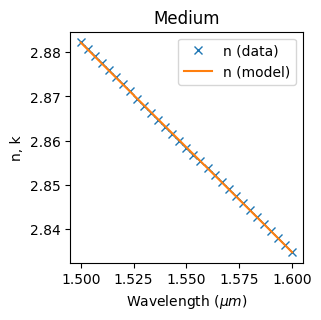

In [13]:
reference_point = (0, -y_wg)
waveguide_point = (0, -y_wg)
other_point = (0, 0)

# Downsample wavelengths to speed up the calculation
spectrum = lambdas_ring[::10]
ring_waveguide_medium = approximate_material(
    sim_ring_3D, waveguide_point, reference_point, spectrum, plot=True
)

In [14]:
ring_background_medium = approximate_material(sim_ring_3D, other_point, reference_point, spectrum)

Output()

As before, we create a 2D copy of the simulation and replace the mediums with those that we just calculated.

Note: removed symmetry, as it is incompatible with the variational approximation method.


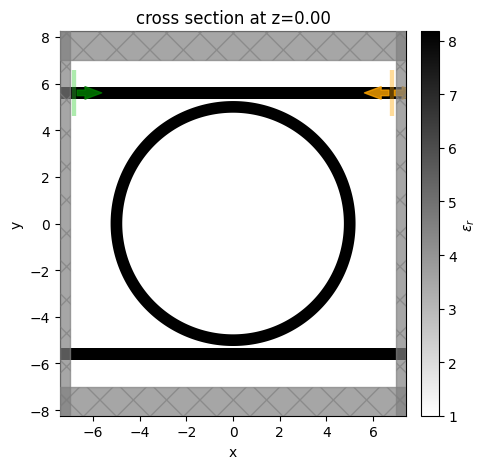

In [15]:
sim_ring_2D = create_2D_sim(sim_ring_3D, [ring_waveguide_medium, ring_background_medium])

sim_ring_2D.plot_eps(z=0, freq=freq0)
plt.show()

In [16]:
sim_data_2D = web.run(sim_ring_2D, task_name="2.5D FDTD ring resonator 2D")
sim_data_3D = web.run(sim_ring_3D, task_name="2.5D FDTD ring resonator 3D")

13:31:11 EST Created task '2.5D FDTD ring resonator 2D' with task_id            
             'fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=114736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=24428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\taskId]8;;\]8;id=114736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\=]8;;\]8;id=201938;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\fdve]8;;\]8;id=114736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\-f748f5dd-588]8;;\
             ]8;id=114736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\4-4d3e-be98-4eefe1f9df95']8;;\.

Output()

13:31:13 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:31:26 EST status = preprocess

13:31:29 EST Maximum FlexCredit cost: 0.203. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

13:31:30 EST running solver

Output()

13:32:16 EST early shutoff detected at 24%, exiting.

             status = postprocess

Output()

             status = success

             View simulation result at                                          
             ]8;id=123452;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=625074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\taskId]8;;\]8;id=123452;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\=]8;;\]8;id=838700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\fdve]8;;\]8;id=123452;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\-f748f5dd-588]8;;\
             ]8;id=123452;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f748f5dd-5884-4d3e-be98-4eefe1f9df95\4-4d3e-be98-4eefe1f9df95']8;;\.

Output()

13:32:17 EST loading simulation from simulation_data.hdf5

             Created task '2.5D FDTD ring resonator 3D' with task_id            
             'fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=166270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=636363;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\taskId]8;;\]8;id=166270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\=]8;;\]8;id=964428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\fdve]8;;\]8;id=166270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\-0f179763-63f]8;;\
             ]8;id=166270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\a-42ff-9c25-6c48fae8cff1']8;;\.

Output()

13:32:19 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:32:47 EST status = preprocess

13:32:49 EST Maximum FlexCredit cost: 4.011. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

14:01:38 EST early shutoff detected at 56%, exiting.

             status = postprocess

Output()

14:01:40 EST status = success

             View simulation result at                                          
             ]8;id=682546;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=367402;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\taskId]8;;\]8;id=682546;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\=]8;;\]8;id=643068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\fdve]8;;\]8;id=682546;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\-0f179763-63f]8;;\
             ]8;id=682546;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f179763-63fa-42ff-9c25-6c48fae8cff1\a-42ff-9c25-6c48fae8cff1']8;;\.

Output()

14:01:41 EST loading simulation from simulation_data.hdf5

### Example 2 Result Comparison

We will compare the results of our 2D and 3D simulations to see how representative our approximation is. As one can see, the resonant behavior of this setup is well-approximated, especially near the central frequency. The depth of the peaks is lower in the 2D simulation because the 3D simulation takes into account vertical coupling. Toward the ends of the spectrum, there is more error in the free spectral range and resonance frequencies, although this is still well within 1% of the resonant wavelength, as we show for the first resonance. However, the next example will show that this method will not always be a good approximation.

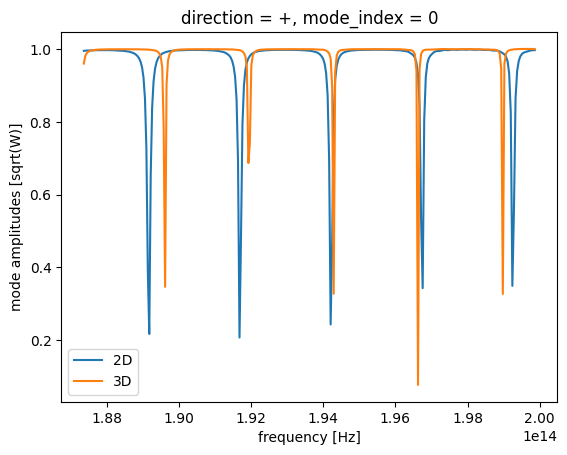

Difference in first resonant wavelength: 0.0033333333333331883


In [17]:
sim_data_2D["mode through"].amps.sel(mode_index=0, direction="+").abs.plot(x="f")
sim_data_3D["mode through"].amps.sel(mode_index=0, direction="+").abs.plot(x="f")
plt.legend(["2D", "3D"])
plt.show()

res_lda_2d = (
    td.C_0 / sim_data_2D["mode through"].amps.sel(mode_index=0, direction="+").abs.f.data[46]
)
res_lda_3d = (
    td.C_0 / sim_data_3D["mode through"].amps.sel(mode_index=0, direction="+").abs.f.data[56]
)
res_wavelength_dif = np.abs(res_lda_2d - res_lda_3d)
print(f"Difference in first resonant wavelength: {res_wavelength_dif}")

## Strip-to-slot Counter-example

This approximation method is not always applicable, and care must be taken to ensure that a given material's approximation is not too far off from the physical constraints of the original material. If not, this can lead to poor approximations. (One can check this by printing out the $n_{eff}^2 + \frac{num}{denom}$ value calculated in the variational method function above.)
<br><br>
We will now show an example where this approximation does not work as well. We will use the first design of our [strip to slot converter example](https://www.flexcompute.com/tidy3d/examples/notebooks/StripToSlotConverters/). First we copy the simulation parameters from the notebook, removing the field monitor, as it will be unnecessary for this illustration:

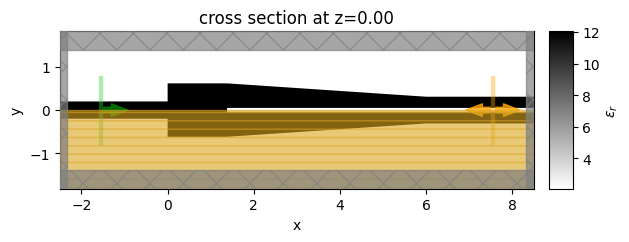

In [18]:
# Define wavelength/frequency ranges
lda0 = 1.55
ldas = np.linspace(1.5, 1.6, 101)
freq0 = td.C_0 / lda0
freqs = td.C_0 / ldas
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

# Create materials
n_si = 3.47
si = td.Medium(permittivity=n_si**2)
n_sio2 = 1.44
sio2 = td.Medium(permittivity=n_sio2**2)

# Define geometry
L_mmi = 1.38
W_mmi = 1.24
L = 6
buffer = 5
h_si = 0.25
w_strip = 0.4
w_slot = 0.62
g = 0.1

vertices = [
    (-buffer, w_strip / 2),
    (0, w_strip / 2),
    (0, W_mmi / 2),
    (L_mmi, W_mmi / 2),
    (L, w_slot / 2),
    (L + buffer, w_slot / 2),
    (L + buffer, g / 2),
    (L_mmi, g / 2),
    (L_mmi, -g / 2),
    (L + buffer, -g / 2),
    (L + buffer, -w_slot / 2),
    (L, -w_slot / 2),
    (L_mmi, -W_mmi / 2),
    (0, -W_mmi / 2),
    (0, -w_strip / 2),
    (-buffer, -w_strip / 2),
]

converter = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_si / 2, h_si / 2)), medium=si
)

# Define mode source
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)
mode_source = td.ModeSource(
    center=(-lda0, 0, 0),
    size=(0, 4 * w_strip, 6 * h_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=7,
)

# Define mode monitor
mode_monitor = td.ModeMonitor(
    center=(L + lda0, 0, 0),
    size=(0, 4 * w_strip, 6 * h_si),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# Define misc. simulation parameters
Lx = L + 3 * lda0
Ly = W_mmi + lda0
Lz = 10 * h_si
sim_size = (Lx, Ly, Lz)

run_time = 1e-12

# construct simulation
sim_splitter_3D = td.Simulation(
    center=(L / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=[converter],
    sources=[mode_source],
    monitors=[mode_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    symmetry=(0, -1, 1),
)

# plot the simulation
sim_splitter_3D.plot_eps(z=0, freq=freq0)
plt.show()

Now we convert the 3D simulation to a 2D simulation, as before.

Output()

Output()

Note: removed symmetry, as it is incompatible with the variational approximation method.


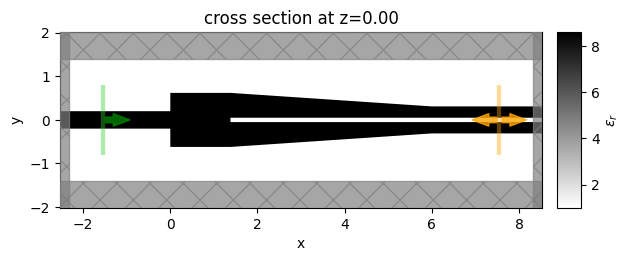

In [19]:
# Approximate materials by downsampling again
spectrum = ldas[::15]
ref_point = (0, 0)
core_point = (0, 0)
other_point = (2, 0)

waveguide_splitter_mat = approximate_material(sim_splitter_3D, core_point, ref_point, spectrum)
background_splitter_mat = approximate_material(sim_splitter_3D, other_point, ref_point, spectrum)

sim_splitter_2D = create_2D_sim(sim_splitter_3D, [waveguide_splitter_mat, background_splitter_mat])
sim_splitter_2D.plot_eps(z=0, freq=freq0)
plt.show()

In [20]:
sim_splitter_data_2D = web.run(sim_splitter_2D, task_name="2.5D FDTD splitter 2D")
sim_splitter_data_3D = web.run(sim_splitter_3D, task_name="2.5D FDTD splitter 3D")

14:01:49 EST Created task '2.5D FDTD splitter 2D' with task_id                  
             'fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=112189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=746483;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\taskId]8;;\]8;id=112189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\=]8;;\]8;id=638851;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\fdve]8;;\]8;id=112189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\-4cb0b3d9-c53]8;;\
             ]8;id=112189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\5-4534-8dc7-04a64653ce14']8;;\.

Output()

14:01:50 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

14:01:55 EST status = preprocess

14:01:56 EST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

14:02:04 EST early shutoff detected at 48%, exiting.

             status = postprocess

Output()

             status = success

14:02:05 EST View simulation result at                                          
             ]8;id=132861;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=668189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\taskId]8;;\]8;id=132861;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\=]8;;\]8;id=984912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\fdve]8;;\]8;id=132861;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\-4cb0b3d9-c53]8;;\
             ]8;id=132861;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4cb0b3d9-c535-4534-8dc7-04a64653ce14\5-4534-8dc7-04a64653ce14']8;;\.

Output()

             loading simulation from simulation_data.hdf5

             Created task '2.5D FDTD splitter 3D' with task_id                  
             'fdve-6d645823-3048-4598-a4c7-8c0959f8685c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=849190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=771626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\taskId]8;;\]8;id=849190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\=]8;;\]8;id=344104;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\fdve]8;;\]8;id=849190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\-6d645823-304]8;;\
             ]8;id=849190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\8-4598-a4c7-8c0959f8685c']8;;\.

Output()

14:02:07 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

14:02:11 EST status = preprocess

14:02:13 EST Maximum FlexCredit cost: 0.055. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

14:02:39 EST early shutoff detected at 36%, exiting.

             status = postprocess

Output()

14:02:43 EST status = success

             View simulation result at                                          
             ]8;id=963963;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=427813;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\taskId]8;;\]8;id=963963;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\=]8;;\]8;id=904508;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\fdve]8;;\]8;id=963963;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\-6d645823-304]8;;\
             ]8;id=963963;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d645823-3048-4598-a4c7-8c0959f8685c\8-4598-a4c7-8c0959f8685c']8;;\.

Output()

14:02:44 EST loading simulation from simulation_data.hdf5

### Counter-example Results

Plotting the mode transmissions from the 2D and 3D simulations, we can see that the 2D transmission is significantly lower than that of the 3D simulation.

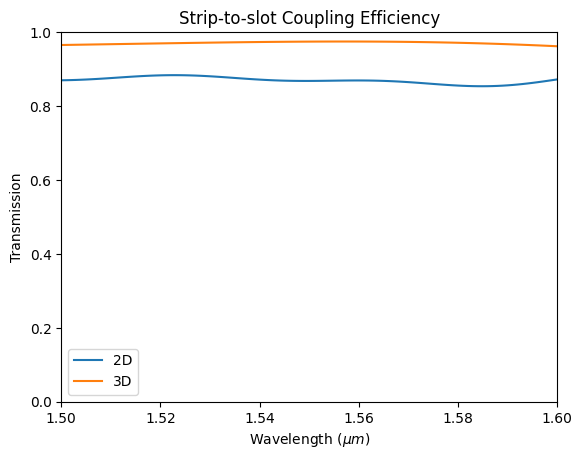

In [21]:
T_2D = np.abs(sim_splitter_data_2D["mode"].amps.sel(mode_index=0, direction="+")) ** 2
T_3D = np.abs(sim_splitter_data_3D["mode"].amps.sel(mode_index=0, direction="+")) ** 2

# plot the coupling efficiency
plt.plot(ldas, T_2D, label="2D")
plt.plot(ldas, T_3D, label="3D")
plt.xlim(1.5, 1.6)
plt.ylim(0, 1)
plt.title("Strip-to-slot Coupling Efficiency")
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission")
plt.legend()
plt.show()

This shows that, depending on the mode profile in z, we can get differences in permittivity from the variational method that do not accurately capture the physics of the original simulation, as mentioned in Hammer & Ivanova. Therefore care must be taken when deciding on this approximation method, and, when possible, a final validation with a 3D simulation should be run.